<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/Gaussian_Mixture_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN


In [33]:
seed = 0

## Gaussian Mixture Model

In [34]:
import numpy as np
from scipy.stats import multivariate_normal
import pdb

def initialize_parameters(X, k):
    n, d = X.shape
    means = X[np.random.choice(n, k, replace=False)]
    covariances = [np.eye(d) for _ in range(k)]
    mixing_coeffs = np.ones(k) / k
    return means, covariances, mixing_coeffs

def compute_responsibilities(X, means, covariances, mixing_coeffs):
    n = X.shape[0]
    k = len(means)
    responsibilities = np.zeros((n, k))
    responsibilities = responsibilities + 1e-10 * np.ones_like(responsibilities) # trying smoothing
    if(np.any(np.isnan(responsibilities))):
        pdb.set_trace()
        print("responsibilities nan")
        print(responsibilities)
        print(mixing_coeffs)

    for j in range(k):
        responsibilities[:, j] = mixing_coeffs[j] * multivariate_normal.pdf(X, mean=means[j], cov=covariances[j], allow_singular=True)

    responsibilities = responsibilities + 1e-10 * np.ones_like(responsibilities)

    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    if(np.any(np.isnan(responsibilities))):
        pdb.set_trace()
        print("responsibilities nan")
        print(responsibilities)
        print(mixing_coeffs)
    return responsibilities

def update_parameters(X, responsibilities):
    n, d = X.shape
    k = responsibilities.shape[1]

    N = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, X) / N[:, np.newaxis]

    covariances = []
    for j in range(k):
        diff = X - means[j]
        covariances.append(np.dot(responsibilities[:, j] * diff.T, diff) / N[j])

    mixing_coeffs = N / n

    if(np.any(np.isnan(means))):
      pdb.set_trace()
      print("means nan")
      print(responsibilities)
      print(X)

    return means, covariances, mixing_coeffs

def compute_log_likelihood(X, means, covariances, mixing_coeffs):
    n = X.shape[0]
    k = len(means)
    log_likelihood = 0

    for i in range(n):
        likelihood = 0
        for j in range(k):
            if(np.any(np.isnan(means))):
              pdb.set_trace()
              print("means nan")
              print(means)
            elif(np.any(np.isnan(covariances))):
              pdb.set_trace()
              print("covariances nan")
              print(covariances)
            elif(np.any(np.isnan(mixing_coeffs))):
              pdb.set_trace()
              print("mixing_coeffs nan")
              print(mixing_coeffs)
            elif(np.all(np.isfinite(means)) == False):
              pdb.set_trace()
              print("means inf")
              print(means)
            elif(np.all(np.isfinite(covariances)) == False):
              pdb.set_trace()
              print("covariances inf")
              print(covariances)
            elif(np.all(np.isfinite(mixing_coeffs)) == False):
              pdb.set_trace()
              print("mixing_coeffs inf")
              print(mixing_coeffs)

            likelihood += mixing_coeffs[j] * multivariate_normal.pdf(X[i], mean=means[j], cov=covariances[j], allow_singular = True)
        log_likelihood += np.log(likelihood)

    return log_likelihood

def gmm_em(X, k, epsilon=1e-6, max_iterations=100):
    means, covariances, mixing_coeffs = initialize_parameters(X, k)
    prev_log_likelihood = -np.inf

    for iteration in range(max_iterations):
        responsibilities = compute_responsibilities(X, means, covariances, mixing_coeffs)
        means, covariances, mixing_coeffs = update_parameters(X, responsibilities)
        log_likelihood = compute_log_likelihood(X, means, covariances, mixing_coeffs)

        if np.abs(log_likelihood - prev_log_likelihood) < epsilon:
            break

        prev_log_likelihood = log_likelihood

    cluster_assignments = np.argmax(responsibilities, axis=1)
    return cluster_assignments, means, covariances, mixing_coeffs

# Example usage:
# X = np.array([...])  # Your data points
# k = 3  # Number of components
# assignments, means, covariances, mixing_coeffs = gmm_em(X, k)

In [35]:

from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms


path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

print("Iris Dataset\n")

start_time = time.time()
# cluters, noise, labels_base_iris = dbscan_base(X_iris, 0.5, 5)
labels_base_iris, means, covariances, mixing_coeffs = gmm_em(X_iris, 4)
print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_iris, labels_base_iris)}")

start_time = time.time()
# dbscan_iris = DBSCAN().fit(X_iris)

# labels_sklearn_iris = dbscan_iris.labels_

def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=4, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_
ini = get_initial_means(X_iris, "kmeans", seed)

gmm = GaussianMixture(
        n_components=4, means_init=ini, tol=1e-6, max_iter=100, random_state=seed
    ).fit(X_iris)

labels_sklearn_iris = gmm.predict(X_iris)

# colors = ["red", "green", "blue", "yellow"]

# for i, color in enumerate(colors):
#         data = X[gmm.predict(X) == i]
#         plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_iris, labels_sklearn_iris)}")

Iris Dataset

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 0 0 0 2 0 2 0 0
 2 2 2 0 0 2 2 2 2 1 0 2 2 0 2 2 0 2 2 2 2 0 2 2 2 2 0 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0]
Execution time (base): 9.108582019805908 seconds
Silhouette score (base): 0.32766455669670796
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 3 0 3 0 3 0 0 0 0 0 0 3 0 0 3 0 3 0 2 0
 3 3 3 3 0 0 0 0 0 2 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2]

Execution time (sklearn): 0.037589073181152344 seconds
Silhouette score (sklearn): 0.406758868463448


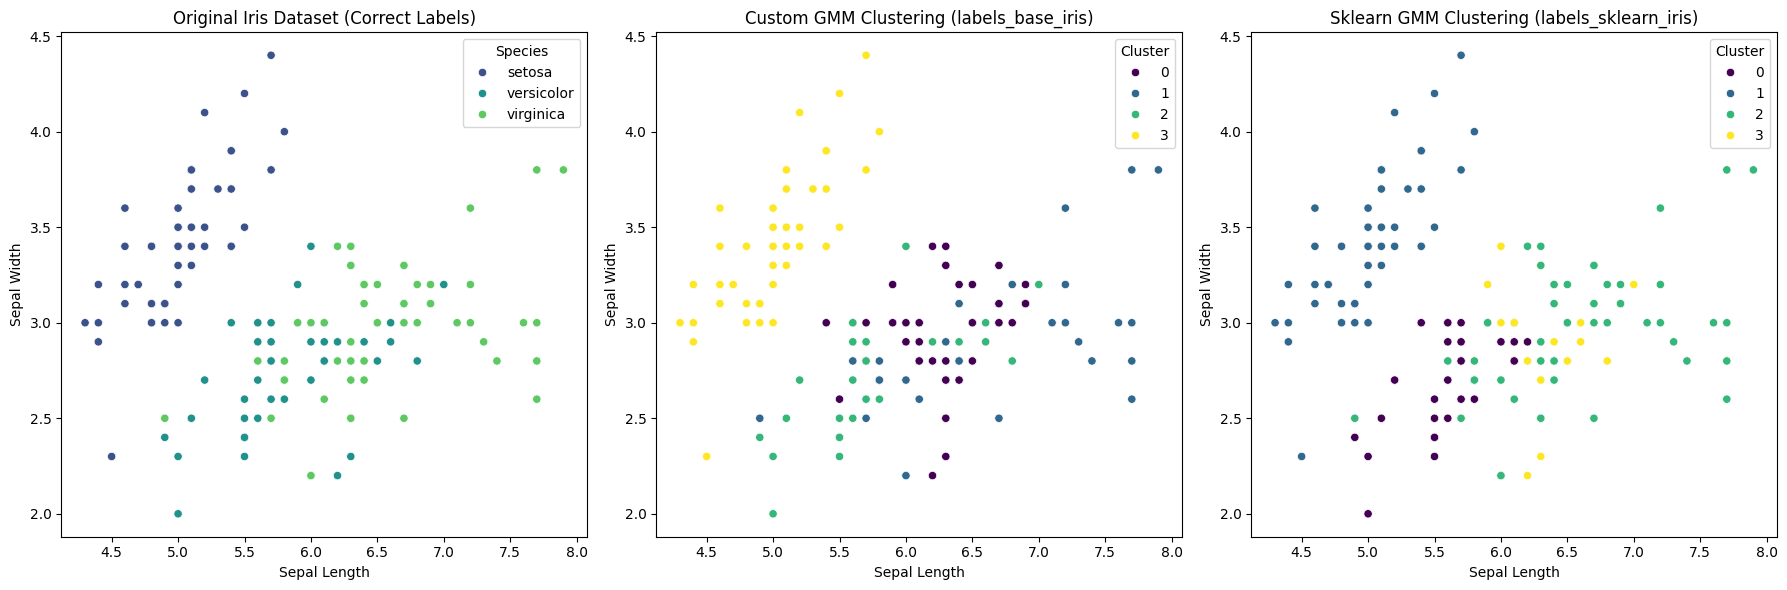

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom GMM Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[1])
axes[1].set_title("Custom GMM Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn GMM Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn GMM Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# AI Dataset

In [37]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

# scaler_ai = StandardScaler()
X_ai = ai_filtered.to_numpy()
k_ai = 3

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

start_time = time.time()


labels_base_ai, means, covariances, mixing_coeffs = gmm_em(X_ai, k_ai)

print(labels_base_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")

start_time = time.time()
# kmeans_ai = KMeans(n_clusters=k_ai, random_state=seed).fit(X_ai)
# labels_sklearn_ai = kmeans_ai.labels_
# centroids_sklearn_ai = kmeans_ai.cluster_centers_

def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=k_ai, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_
ini = get_initial_means(X_ai, "kmeans", seed)

gmm = GaussianMixture(
        n_components=k_ai, means_init=ini, tol=1e-6, max_iter=100, random_state=seed
    ).fit(X_ai)

labels_sklearn_ai = gmm.predict(X_ai)

print(labels_sklearn_ai)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
# print(f"Silhouette score (sklearn): {silhouette_score(X_ai, labels_sklearn_ai)}")

AI Global Index
[2 2 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Execution time (base): 1.050767183303833 seconds
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 2 2 0
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Execution time (sklearn): 0.029831886291503906 seconds


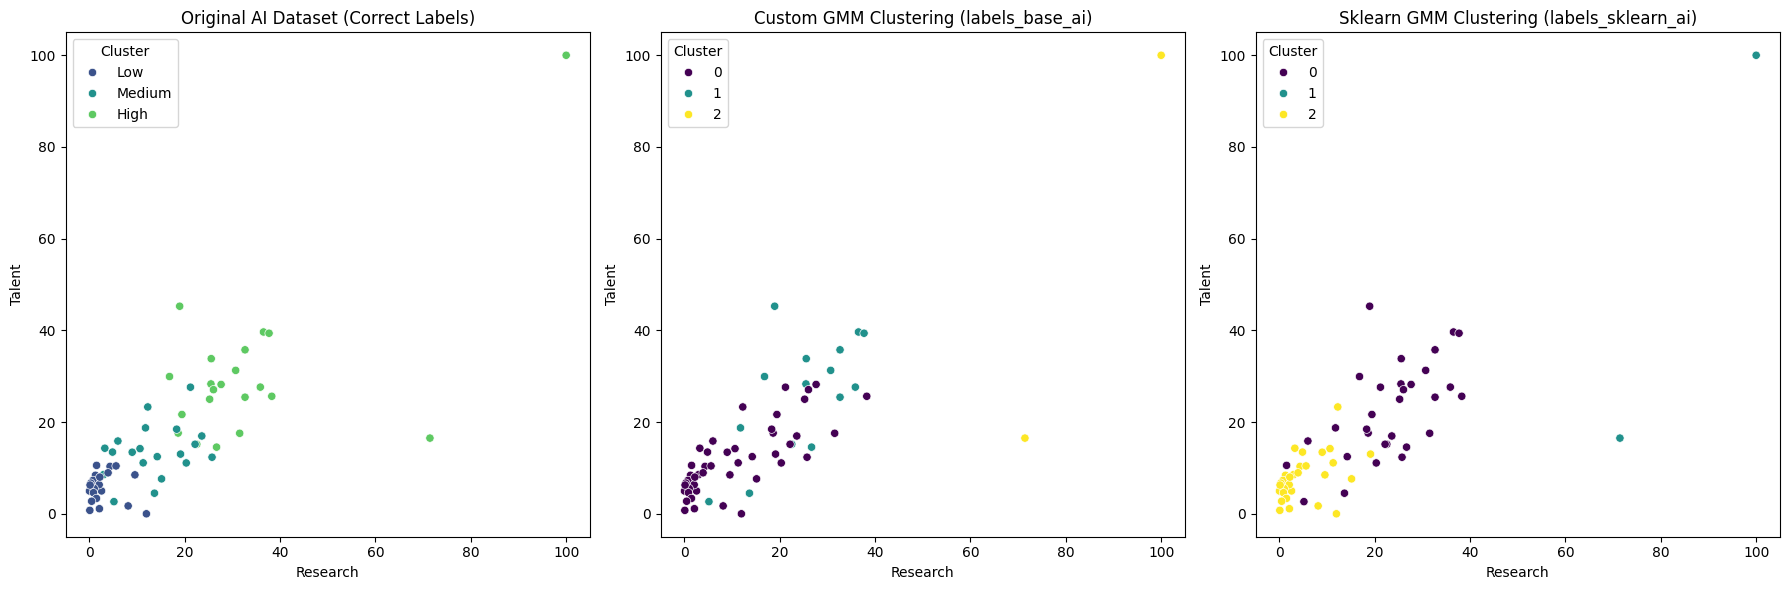

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom GMM Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn GMM Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [39]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()

k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)


labels_base_earth, means, covariances, mixing_coeffs = gmm_em(X_earth, k_earth)

print(labels_base_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_earth, labels_base_earth)}")

start_time = time.time()


ini = GaussianMixture(
        n_components=4, init_params="kmeans", tol=1e-9, max_iter=0, random_state=seed
    ).fit(X_earth).means_

gmm = GaussianMixture(
        n_components=k_earth, means_init=ini, tol=1e-6, max_iter=100, random_state=seed
    ).fit(X_earth)

labels_sklearn_earth = gmm.predict(X_earth)
print(labels_sklearn_earth)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_earth, labels_sklearn_earth)}")

Global Earthquake Data
[0 0 2 ... 0 2 2]
Execution time (base): 5.464799165725708 seconds
Silhouette score (base): -0.20067707992640116
[0 0 0 ... 0 0 0]

Execution time (sklearn): 0.04381275177001953 seconds
Silhouette score (sklearn): 0.9568851143031006


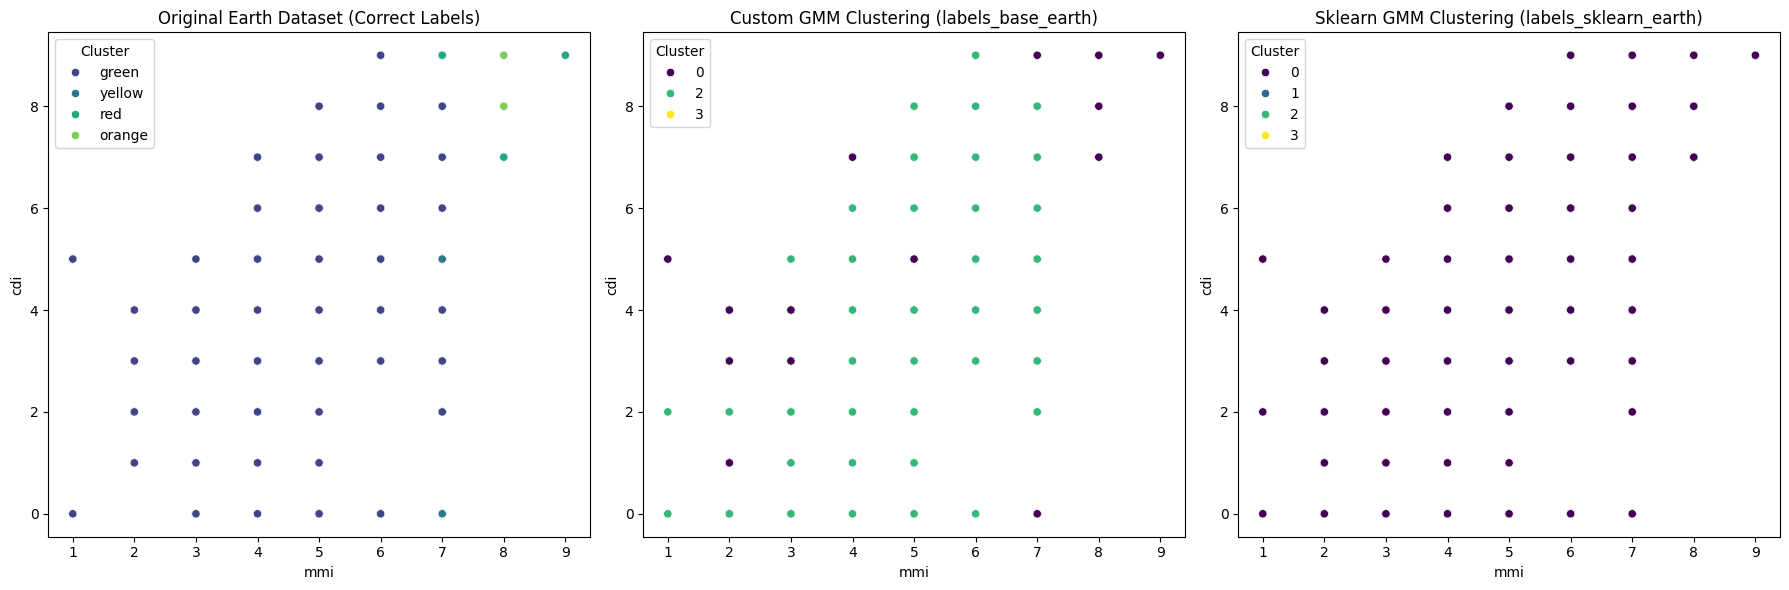

In [42]:
# cdi_idx = list(earthquakes_filtered.columns).index("cdi")
# mmi_idx = list(earthquakes_filtered.columns).index("mmi")

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
# plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, cdi_idx], c='red', marker='x', s=150, label='Centroids (base)')
# plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, cdi_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

# plt.xlabel("mmi")
# plt.ylabel("cdi")
# plt.title("mmi vs. cdi in Global Earthquake dataset")
# plt.legend(title="Legend")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom GMM Clustering (labels_base_earth)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn GMM Clustering (labels_sklearn_earth)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

NameError: name 'GM' is not defined